# New York Stock Exchange
S&P 500 companies historical prices with fundamental data

https://www.kaggle.com/dgawlik/nyse

In [ ]:
from google.colab import drive
import keras
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer  
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import optimizers
import pandas as pd
import numpy
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
import unicodedata
import html
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:

drive.mount("/content/colab/")

Drive already mounted at /content/colab/; to attempt to forcibly remount, call drive.mount("/content/colab/", force_remount=True).


In [ ]:
%cd "colab/MyDrive/Assignment8"

[Errno 2] No such file or directory: 'colab/MyDrive/Assignment8'
/content/colab/MyDrive/Assignment8


In [ ]:
# # Install Kaggle API
# !pip install --quiet kaggle

# import os
# if '.kaggle' not in os.listdir('/root'):
#     !mkdir ~/.kaggle

# # !mkdir -p ~/.kaggle
# !cp /content/kaggle.json ~/.kaggle/

# !chmod 600 /root/.kaggle/kaggle.json

# # Get the dataset
# !kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

In [ ]:
!ls

'archive(1).zip'    LSTM.h5	 prices-split-adjusted.csv
 fundamentals.csv   prices.csv	 securities.csv


# Frame the problem

Predicting  Apple's stock prices 

https://www.investopedia.com/articles/basics/06/invest1000.asp

https://www.youtube.com/watch?v=ftMq5ps503w


In [ ]:
prices=pd.read_csv("prices.csv")
securities=pd.read_csv("securities.csv")
fundamentals=pd.read_csv("fundamentals.csv")
prices=pd.read_csv("prices-split-adjusted.csv",parse_dates=["date"])

# Understanding the  data

*In stock trading, the high and low refer to the maximum and minimum prices in a given time period. Open and close are the prices at which a stock began and ended trading in the same period. Volume is the total amount of trading activity.*

Previous close by definition in stock market language refers to essentially the last trading price of the previous day, while open price refers to the first trading price of the day. Investors can change their minds based on new information about what a stock is worth while it's closed, meaning prices can shift without any trades taking place.

**So, what causes a stock to rise or fall in the market? **Well, basically the supply and demand forces of the market determine how much stock is available for sale. And it all boils down to the "buy-sell" strategy. When a company is making money, it needs buyers to buy up its stock, so the company offers incentives to do just that.
## How a Stock Price Works

At the grocery store, prices are marked right there on the shelf. If peaches are 69 cents a can, then that's what you'll pay for them.

But in the stock market, prices are fluid. The price quoted for a stock at any point is simply the price paid the last time that stock changed hands. There's no guarantee that you'll get that price if you place an order to buy or sell shares. Stock exchanges match buyers and sellers, and prices are set through the interplay of what buyers are willing to pay and what sellers are willing to accept.

Technically, there are bid prices, meaning what people are offering for the stock, and ask prices, meaning what people are looking to be paid for it. When those prices converge, trades take place.

## Exploring the Closing Price

The listed closing price is the last price anyone paid for a share of that stock during the business hours of the exchange where the stock trades. The major U.S. exchanges are generally open from 9:30 a.m. to 4 p.m. Eastern time. The closing price is just a snapshot of the stock at 4 p.m.

This price does carry a lot of psychological weight, as it's often interpreted as the market's "final say" on a stock for the day.

## Assessing the Open Price

Just as the closing price is the price paid in the last transaction of a business day, the opening price is the price from the first transaction of a business day. That price can be influenced by anything that has happened since the previous close.

Imagine a company whose stock closes one day at  20 dollars a share. That night, news breaks that the company has perpetrated a massive accounting fraud and is in dire financial shape. When the market opens the next day, no one is going to pay 20 dollars a share for the stock, because it's not worth that. If the most anyone is willing to pay is 2dollar a share, then the stock will open at $2.


## Why is a Stock’s Closing Price Significant?

While much fanfare surrounds the stock market’s opening bell and opening prices, it is a stock’s closing price that **determines how a share performed during the day**.
The close price is considered the reference point for any time frame. It’s the price traders agreed on after all the action throughout the day. When researching historical stock price data, financial institutions, regulators, and individual investors use the closing price as the standard measure of the stock’s value as of a specific date. For example, a stock’s close on December 31, 2019, was the closing price for not only that day, but also that week, month, quarter, and year.

https://finance.zacks.com/open-stock-price-different-closed-stock-price-6656.html

https://analyzingalpha.com/open-high-low-close-stocks

In [ ]:
prices.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [ ]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    851264 non-null  datetime64[ns]
 1   symbol  851264 non-null  object        
 2   open    851264 non-null  float64       
 3   close   851264 non-null  float64       
 4   low     851264 non-null  float64       
 5   high    851264 non-null  float64       
 6   volume  851264 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 45.5+ MB


In [ ]:
securities[securities["Ticker symbol"]=="AAPL"]

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
45,AAPL,Apple Inc.,reports,Information Technology,Computer Hardware,"Cupertino, California",1982-11-30,320193


we'll only consider apple's stock.

In [ ]:


stocks=prices[prices["symbol"]=="AAPL"].set_index("date")
stocks.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0


# |EDA


## Time-series plot types¶
### Lag plot

One of these plot types is the lag plot. A lag plot compares data points from each observation in the dataset against data points from a previous observation. So for example, data from December 21st will be compared with data from December 20th, which will in turn be compared with data from December 19th, and so on. For example, here is what we see when we apply a lag plot to the volume (number of trades conducted) in the stock data:


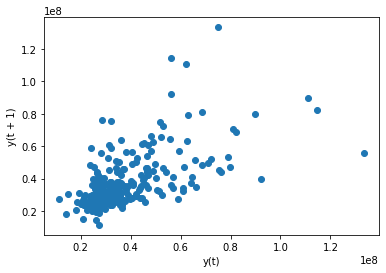

In [ ]:

from pandas.plotting import lag_plot
lag_plot(stocks["volume"].tail(250))



It looks like days when volume is high are somewhat correlated with one another. A day of frantic trading does somewhat signal that the next day will also involve frantic trading.

### Autocorrelation plot

 These are plots that graphically summarize the **strength of a relationship with an observation in a time series with observations at prior time steps.**
 
  It does this by computing a summary statistic—the correlation score—across every possible lag in the dataset. This is known as autocorrelation.

`In an autocorrelation plot the lag is on the x-axis and the autocorrelation score is on the y-axis.` **The farther away the autocorrelation is from 0, the greater the influence that records that far away from each other exert on one another.**

Here is what an autocorrelation plot looks like when applied to the stock volume data

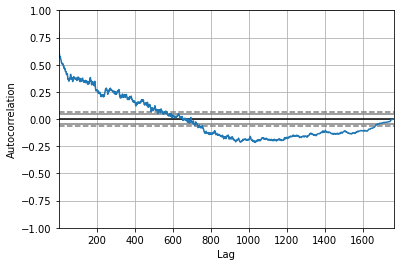

In [ ]:


from pandas.plotting import autocorrelation_plot
autocorrelation_plot(stocks["volume"])

It seems like the volume of trading activity is weakly descendingly correlated with trading volume from the year prior.

## Price vs.days

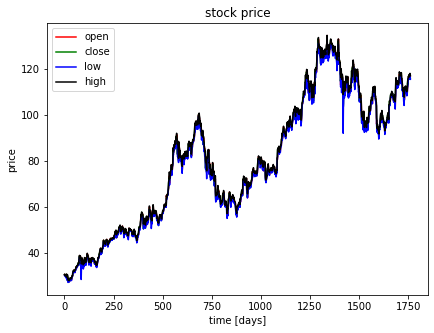

In [ ]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(stocks.open.values, color='red', label='open')
plt.plot(stocks.close.values, color='green', label='close')
plt.plot(stocks.low.values, color='blue', label='low')
plt.plot(stocks.high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()





# Visualize output variable

In [ ]:
plt.figure(figsize=(12,8))
ax = train_set['close'].plot(label='train')
ax = validation_set['close'].plot(ax=ax, label='validation')
test_set['close'].plot(ax=ax, label='test')
plt.title('Apple Closing Stock Distibution Among Train, Validation And Test Set')
plt.xlabel('Date')
plt.ylabel('Closing Stock')
plt.legend()
plt.show()

slight upward linear trend

# Data Cleaning

## Duplicates

In [ ]:
stocks[stocks.duplicated(keep=False)].reset_index()

,date,symbol,open,close,low,high,volume


## Checknull values

In [ ]:
stocks.isnull().sum()/ stocks.shape[0]*100

symbol    0.0
open      0.0
close     0.0
low       0.0
high      0.0
volume    0.0
dtype: float64

# LSTM Network for Regression

We can phrase the problem as a regression problem.

That is, given the closing price (in dollars) this month, what is the closing price next day?

We can write a simple function to convert our single column of data into a two-column dataset: the first column containing this month’s (t) closing price and the second column containing *next month’s (t+1) closing price, to be predicted*

# Prepare the data for Machine Learning algorithms

DataTypes>>numeric>

## FeaturesScaling

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the **MinMaxScaler** preprocessing class from the scikit-learn library.

In [ ]:
stocks.drop("symbol",axis=1,inplace=True)

In [ ]:
stocks_close=stocks.close.values.astype("float64").reshape(1762,1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
stocks_scaled = scaler.fit_transform(stocks_close)


In [ ]:
stocks_close[0]

array([30.57285686])

## train/test split

With time series data, **the sequence of values is important**. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 80% of the observations that we can use to train our model, leaving the remaining 20% for testing the model.

In [ ]:


#
train_size=int(len(stocks_scaled)*0.80)
test_size=len(stocks_scaled)-train_size
train,test=stocks_scaled[0:train_size,:],stocks_scaled[train_size:len(stocks_scaled),:]
print(len(train), len(test))


1409 353


In [ ]:
train[0]

## Prepare dataset 

Now we can define a function to create a new dataset, as described above.

The function takes two arguments: 
- the dataset, which is a NumPy array that we want to convert into a dataset, 
- the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset,look_back=1):
  dataX,dataY=[],[]
  for i in range(len(dataset)-look_back-1):
    #col. with index 1 corresponds to close_price,(predicteedVariable)
    a=dataset[i:(i+look_back),1]
    dataX.append(a)
    dataY.append(dataset[i+look_back,1])
  return np.array(dataX),np.array(dataY)

In [ ]:


# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


In [ ]:
train

In [ ]:
trainX[:10]

array([[[0.02971784]],

       [[0.03021854]],

       [[0.02560389]],

       [[0.02507612]],

       [[0.0269707 ]],

       [[0.02444008]],

       [[0.02120576]],

       [[0.02517085]],

       [[0.02351986]],

       [[0.0187834 ]]])

In [ ]:
trainY[:10]

array([0.03021854, 0.02560389, 0.02507612, 0.0269707 , 0.02444008,
       0.02120576, 0.02517085, 0.02351986, 0.0187834 , 0.0311117 ])

## Reshape

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: `[samples, time steps, features].`

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using **numpy.reshape()** as follows:

In [ ]:


trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



In [ ]:
import time 

In [ ]:
#Step 2 Build Model
model = models.Sequential()

model.add(layers.LSTM(units=100,
    input_dim=1,
    return_sequences=True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(
    100,
    return_sequences=False))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(
    1))
model.add(layers.Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

compilation time :  0.007922887802124023


In [ ]:
history=model.fit(
    trainX,
    trainY,
    batch_size=128,
    epochs=10,
    validation_split=0.05)

Epoch 1/10
11/11 [==============================] - 4s 120ms/step - loss: 0.1796 - val_loss: 0.4580
Epoch 2/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0693 - val_loss: 0.1511
Epoch 3/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0229 - val_loss: 0.0662
Epoch 4/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0164 - val_loss: 0.0284
Epoch 5/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0106 - val_loss: 0.0143
Epoch 6/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0052 - val_loss: 7.9184e-04
Epoch 7/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 8/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0019 - val_loss: 8.6477e-04
Epoch 9/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 10/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0018 - val_loss: 0.0033


In [ ]:
model.save("LSTM.h5")

In [ ]:
history

# PlotLearningCurve

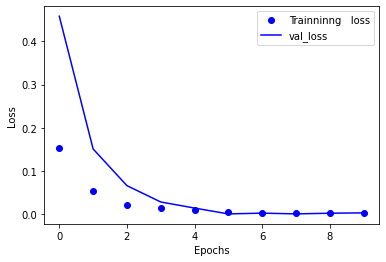

In [ ]:
import matplotlib.pyplot  as  plt
train_loss =     history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(  train_loss,  "bo", label = "Trainninng   loss")
plt.plot( val_loss, "b", label =  "val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluate theModel>>visualize

Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, **we must shift the predictions **so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

In [ ]:
testY.shape

In [ ]:
test_Y_=np.array(testY)
test_Y_ = np.reshape(test_Y_, (-1,1))

In [ ]:
predicted_y.shape

(351, 1)

In [ ]:
test_Y_.shape

(351, 1)

In [ ]:
predicted_y=model.predict(testX)
predicted_y_denorm=scaler.inverse_transform(predicted_y)
actual_y=  scaler.inverse_transform(test_Y_)
predicted_y_denorm.shape

(351, 1)

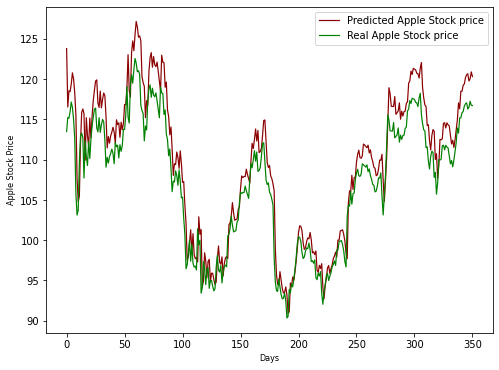

In [ ]:
plt.figure(figsize=(8,6))
plt.subplot(1,1,1)
plt.plot(predicted_y_denorm, linewidth=1.2, color='darkred', label='Predicted Apple Stock price')
plt.plot(actual_y, linewidth=1.2, color='green', label='Real Apple Stock price')
plt.xlabel('Days', fontsize=8)
plt.ylabel('Apple Stock Price', fontsize=8)
plt.legend(loc='best', fontsize=10)
plt.show()

We can see that the model did an excellent job of fitting both the training and the test datasets. 

# Resources

https://www.kaggle.com/residentmario/time-series-plotting-optional

https://www.kaggle.com/debu3kaggle/stock-exchange-analysis-using-lstm

https://www.kaggle.com/raoulma/ny-stock-price-prediction-rnn-lstm-gru

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

https://www.youtube.com/watch?v=ftMq5ps503w